<a href="https://colab.research.google.com/github/Sarwan-09/AI-Bootcamp-Assig1/blob/main/AI_bootcamp_Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# About the Dataset


The karpathy/tiny_shakespeare dataset contains about 1 million characters of text from Shakespeare's works, such as Hamlet, Macbeth, and Romeo and Juliet. It is often used for training character-level language models, such as GPT-2, to generate text in the Shakespearean style.

Key Points:

*  Structure: The dataset has three splits: train, validation, and test.

*  Format: Each line is a separate text fragment.


*  Size: About 1 million characters (small dataset).

*  Preprocessing: Character-level tokenization, with no punctuation (only
   lowercase letters and spaces).

*  Usage: Ideal for text generation tasks or fine-tuning language models to
   generate Shakespeare-like text.








### We first import nesseccery libraries

In [ ]:
from datasets import load_dataset
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from transformers import TrainingArguments
from transformers import Trainer
from transformers import pipeline

### Importing the dataset

In [ ]:
dataset = load_dataset("karpathy/tiny_shakespeare")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 1
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 1
    })
    test: Dataset({
        features: ['text'],
        num_rows: 1
    })
})

### Load GPT-2

In [ ]:
# Loading GPT-2 model and tokenizer
model = GPT2LMHeadModel.from_pretrained("gpt2")
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# Setting padding token to EOS (End-of-Sequence) token
tokenizer.pad_token = tokenizer.eos_token


### Tokenizer

In [ ]:
def tokenize_and_align_labels(examples):
    tokenized = tokenizer(examples["text"], truncation=True, padding="max_length", max_length=128)

    # Adding labels (same as input_ids for causal language modeling)
    tokenized["labels"] = tokenized["input_ids"].copy()
    return tokenized

# Applying the tokenization function to the train, validation, and test datasets
train_dataset = dataset["train"].map(tokenize_and_align_labels, batched=True)
validation_dataset = dataset["validation"].map(tokenize_and_align_labels, batched=True)
test_dataset = dataset["test"].map(tokenize_and_align_labels, batched=True)

# Setting the format for PyTorch
train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
validation_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

### Define Training Arguments

In [ ]:
training_args = TrainingArguments(
    output_dir="./gpt2_shakespeare",
    evaluation_strategy="epoch",
    logging_dir="./logs",
    save_strategy="epoch",
    num_train_epochs=6,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    logging_steps=100,            )

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    tokenizer=tokenizer,
)

<ipython-input-11-6e80dc5f6253>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


### Train the Model

In [ ]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: ertc11m210105 (chiman-salh-erbil-polytechnic-university). Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss
1,No log,3.687916
2,No log,3.418732
3,No log,3.307358
4,No log,3.263676
5,No log,3.236826
6,No log,3.230690


TrainOutput(global_step=6, training_loss=3.095028877258301, metrics={'train_runtime': 87.39, 'train_samples_per_second': 0.069, 'train_steps_per_second': 0.069, 'total_flos': 391938048000.0, 'train_loss': 3.095028877258301, 'epoch': 6.0})

### Evaluate the Model

In [ ]:
eval_results = trainer.evaluate()
print(eval_results)

{'eval_loss': 3.2306902408599854, 'eval_runtime': 0.0215, 'eval_samples_per_second': 46.507, 'eval_steps_per_second': 46.507, 'epoch': 6.0}


- **`eval_loss` = 3.231**: A slight improvement from 3.305, indicating better performance. The model is learning, but there's still room to optimize.
- **`eval_runtime` = 0.0215** and **`eval_samples_per_second` = 46.507**: The evaluation is efficient.


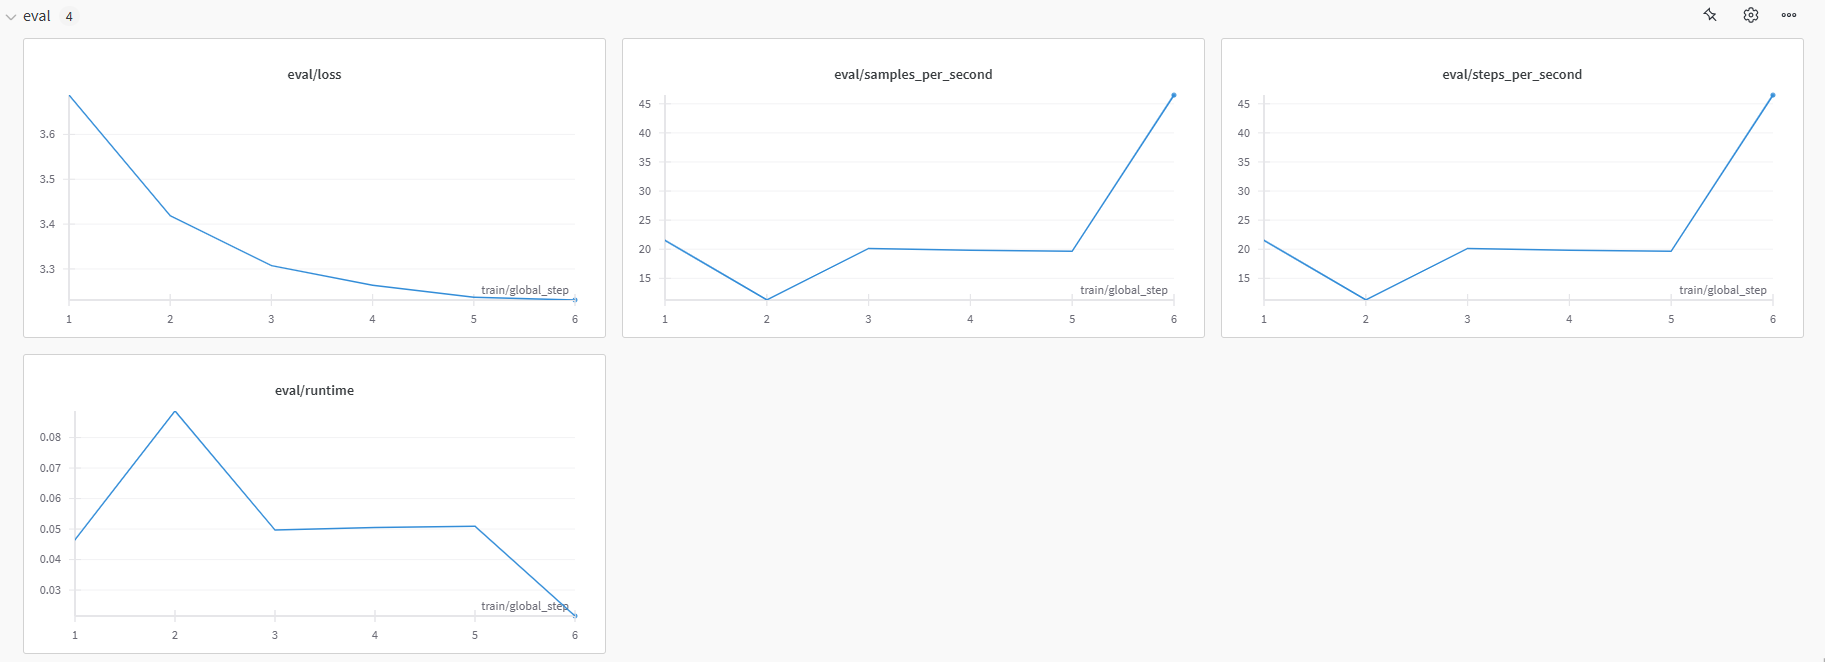

### Input Example

In [ ]:
generator = pipeline("text-generation", model=model, tokenizer=tokenizer)

# prompt
prompt = "O Romeo, Romeo! wherefore art thou Romeo?"
generated_text = generator(prompt, max_length=100, num_return_sequences=1 , truncation=True)
print(generated_text[0]["generated_text"])

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


O Romeo, Romeo! wherefore art thou Romeo? Let the wind blow down and we are all together at once in this beautiful hour,

Let us all together and let us be in one body at once and to save the world we die in that hour

And let the wind blow up let us go and I will be a king that shall rule over all the earth

And to hear and you shall hear. And what is this a mighty battle cry,

A mighty



### Suggestions for Improvement:
1. **Tune Hyperparameters**: Experiment with learning rate, batch size, and sequence length to reduce loss.
2. **Use Regularization**: Implement dropout or weight decay to avoid overfitting.
3. **Larger Dataset**: Fine-tune on a larger corpus or augment your data to improve generalization.
4. **Learning Rate Scheduling**: Use a scheduler to decrease the learning rate during training.


### Steps Taken to Fine-Tune GPT-2 on Shakespeare Dataset:

1. **Load the Dataset**:
   - Used the `datasets` library to load the `karpathy/tiny_shakespeare` dataset.
   - Dataset contained `train`, `validation`, and `test` splits.

2. **Tokenization**:
   - Loaded GPT-2 tokenizer using `transformers`.
   - Set the padding token to the EOS token (GPT-2 doesn't have a default padding token).
   - Tokenized the Shakespeare text into input IDs and attention masks.

3. **Preprocessing**:
   - Created labels by shifting the input tokens by one position to predict the next token.
   - Padded/truncated the tokenized sequences to a fixed maximum length.

4. **Data Preparation**:
   - Converted the tokenized dataset into PyTorch tensors using the `DataCollatorForLanguageModeling` for dynamic padding.

5. **Define Model and Training**:
   - Loaded the pre-trained GPT-2 model (`gpt2`).
   - Used the `Trainer` API to set up training with:
     - TrainingArguments (e.g., batch size, learning rate, epochs).
     - Train and evaluation datasets.
     - Evaluation strategy set to `epoch`.

6. **Training**:
   - Fine-tuned GPT-2 on the Shakespeare dataset.
   - Monitored training and validation loss at each epoch.

7. **Evaluation**:
   - Evaluated the model on the validation set to calculate `eval_loss`.
   - Adjusted hyperparameters for improved performance.

8. **Text Generation**:
   - Used the fine-tuned model to generate Shakespeare-like text by providing a prompt and sampling the output.

### Key Tools:
- `datasets`, `transformers` (Hugging Face library)
- PyTorch
- `Trainer` API for simplified fine-tuning and evaluation